![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="images/practicumai_transfer_learning.png" alt="Practicum AI: Transfer Learning icon" align="right" width=50>
***

# Transfer Learning Concepts

You may recall *Practicum AI*'s heroine Amelia, the AI-savvy nutritionist. At the end of our *[Deep Learning Foundations course](https://practicumai.org/courses/deep_learning/)*, Amelia was helping with a computer vision project. If only she had known about transfer learning, it could have saved her a lot of time! In this notebook, we will get some hands-on experience with transfer learning and show you how to use it to improve your workflows.

<img src='images/agrinet_figure-cover.jpg' alt="Figure 2 of the AgriNet paper used as the cover image for this notebook. Figure 2 depicts using transfer learning to make a computer vision model more efficient" width=60%>

## AgriNet background

This exercise is based off the 2022 Sahili and Awad *Frontiers in Plan Sciences* paper [The power of transfer learning in agricultural applications: AgriNet](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2022.992700/full). In this paper Sahili and Awad explore different models using a large dataset of over 160,000 images. While the full dataset is too large for this exercise, we have made a subset of the data, and will use a similar approach as we explore transfer learning.

## AI Pathway review for transfer learning & AgriNet 

If you have taken our [Getting Started with AI course](https://practicumai.org/courses/getting_started/), you may remember this figure of the AI Application Development Pathway. Let's take a quick review of how we will apply this to our case study of AgriNet and it's use of transfer learning.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we will be trying to make a computer vision model that can recognize images of plants, and categorize them as "healthy", or in one or more disease classes. As you will see when you explore the data, there are over 20 crops and some have as many as 11 disease states. In total, there are 73 categories!
2. **Gather data:** The data for the example comes from [HuggingFace](https://huggingface.co/datasets/zahraa/AgriNet), a great repository of datasets, code, and models. 
3. **Clean and prepare the data:** While the dataset is already fairly good, we have done some further processing of the data:
    * We have removed some crops with no "healthy" category. We have combined lemon into the Citrus category. We dropped some crops with relatively few images. 
    * Most importantly, we have made the dataset a bit more realistic and manageable for the course. **We have randomly subsampled the images so that each category has no more than 100 images in the training set**.
    * The details of the modifications are in the [Data_processing.ipynb notebook](Data_processing.ipynb).
4. **Choose a model:** For reasons of efficiency and training speed, we will use the EfficientNet-B5 model (more on that below). The EfficientNet models are Convolutional Neural Networks (CNNs). We will train from scratch as a baseline (using only the model architecture, not the pre-trained weights), and compare that to starting with a pre-trained model that we fine-tune on the AgriNet dataset. We will use an EfficientNet-B5 model trained on the ImageNet dataset, which is a large dataset of images with 1,000 classes. By fine-tuning this model, we can leverage the knowledge the model has learned from the ImageNet dataset and apply it to our specific problem of plant disease classification. Since the *domain* of ImageNet is distinctly different (1,000 everyday objects) from the domain of AgriNet (healthy and diseased plants), this is a **Domain Transfer** example. 
   * In the step where you'd choose a model, one can approach this many ways, for this notebook we'll just mention two:
      * **Train from scratch:** This is where you start with a randomly initialized model and train it on your data. This can be computationally expensive and time-consuming.
      * **Domain Transfer via Fine-Tuning:** This is where you start with a pre-trained model and fine-tune it on your data. This is often faster and requires less data.
5. **Train the model:** As mentioned in step 4, we'll demonstrate two approaches in this notebook:
      - Training the EfficientNet model architecture from scratch.
      - Fine-tuning an EfficientNet model pre-trained on ImageNet, a domain-specific dataset to achieve Domain Transfer.
6. **Evaluate the model:** We will use the metrics we gather to make decisions about the model. 
7. **Deploy the model:** We won't get to this stage in this course, but ideally we would end up with a model that could be deployed and achieve relatively good accuracy at solving crop classification problems.




## PyTorch Lightning 

<img src='images/Lightning_logo.svg' alt="PyTorch Lightning logo" width=25%>

[PyTorch Lightning](https://lightning.ai/) is an open-source framework built on top of PyTorch that makes training deep learning models more straightforward. It abstracts many common tasks like managing training loops, logging, checkpointing, and handling hardware setups, allowing you to focus on the core aspects of your model and experimentation. 

Rather than writing repetitive code, you define key methods—such as `training_step` and `validation_step`—to describe the model's behavior while the Lightning trainer automates optimization details, synchronization, and even distributed training. This separation between scientific code and engineering routines leads to cleaner, more maintainable projects that are easier to scale.

Additionally, PyTorch Lightning integrates smoothly with popular tools such as [TensorBoard](https://www.tensorflow.org/tensorboard), which simplifies tracking experiment metrics and visualizing performance. Overall, Lightning streamlines the training workflow, boosts reproducibility, and helps both beginners and seasoned researchers concentrate on innovation, not boilerplate coding.

This course will make use of Lightning to simplify training.


## 1. Import libraries

First, let's import the libraries we'll need. PyTorch is a popular open-source machine learning library for Python, and is developed by Facebook's AI Research lab (FAIR). We'll also use PyTorch Lightning and other common libraries

In [1]:
import os

import matplotlib.pyplot as plt
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import ImageFile
from pytorch_lightning import Trainer

from torchvision import datasets, transforms

# Import EfficientNet-B5
from torchvision.models import efficientnet_b5

import helpers

#### Check for GPU availability

This cell will check that everything is configured correctly to use your GPU. If everything is correct, you should see something like: 

    Using GPU: [type of GPU]

If you see:
    
    Using CPU
    
Either you do not have a GPU or the kernel is not correctly configured to use it. You might be able to run this notebook, but some sections will take a loooooong time!


In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name()}")
else:
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-80GB


## How to use this notebook's `FIX_ME`s

In this notebook, you'll find sections marked with:

```
# FIX_ME: <description of what to do>
```
These are places where you need to fill in missing code or make adjustments. The goal is to reinforce the key implementation steps for each technique.

If you get stuck, review the preceding explanations, check the documentation for the libraries used (PyTorch, Hugging Face), or consult the course's **GitHub Discussions page** [Link to GitHub Discussions - Placeholder] for hints and help from peers and instructors.


## 2. Load the data

First, we'll download, unpack and load the data. The data is unpacked into the `data` directory, with the training, validation and test sets loaded into `agri_net_train`, `agri_net_val` and `agri_net_test` respectively.

In [3]:
# Define paths to dataset
data_path = "data"
train_dir = os.path.join(data_path, "agri_net_train100")
val_dir = os.path.join(data_path, "agri_net_val")
test_dir = os.path.join(data_path, "agri_net_test")

# Download and extract the dataset
download_url = "https://data.rc.ufl.edu/pub/practicum-ai/Transfer_Learning"
file_name = "agrinet_image_data.tar.gz"
folder_names = ["agri_net_train100", "agri_net_val", "agri_net_test"]

helpers.download_and_extract_data(download_url, file_name, data_path, folder_names)

Data is already downloaded.


## 3. Look at the data
We will take a look at the data to see what we are working with. This is a good practice to get a sense of the data and to see if there are any issues that need to be addressed.

Number of training images: 7,192
Number of validation images: 5,973
Number of test images: 11,976


There are 73 classes in the dataset, with the labels:
   Alstonia_Scholaris_Diseased, Alstonia_Scholaris_Healthy, 
   Apple_Apple_Scab, Apple_Black_Rot, Apple_Cedar_Apple_Rust, Apple_Healthy, 
   Arjun_Diseased, Arjun_Healthy, 
   Background_Without_Leaves, 
   Bean_Angular_Leaf_Spot, Bean_Healthy, Bean_Rust, 
   Cassava_Bacterial_Blight, Cassava_Green_Mite, Cassava_Healthy, Cassava__Brown_Streak_Disease, Cassava__Mosaic_Disease, 
   Cherry_Healthy, Cherry_Powdery_Mildew, 
   Chinar_Diseased, Chinar_Healthy, 
   Citrus_Diseased, Citrus_Healthy, 
   Coffee_Cercospora, Coffee_Healthy, Coffee_Miner, Coffee_Phoma, Coffee_Rust, 
   Corn_Cercospora__Gray_Leaf_Spot, Corn_Common_Rust, Corn_Healthy, Corn_Northern_Leaf_Blight, 
   Cotton_Leaf_Diseased, Cotton_Leaf_Healthy, Cotton_Plant_Diseased, Cotton_Plant_Healthy, 
   Gauva__Diseased, Gauva__Healthy, 
   Grape_Black_Rot, Grape_Esca_Black_Measle

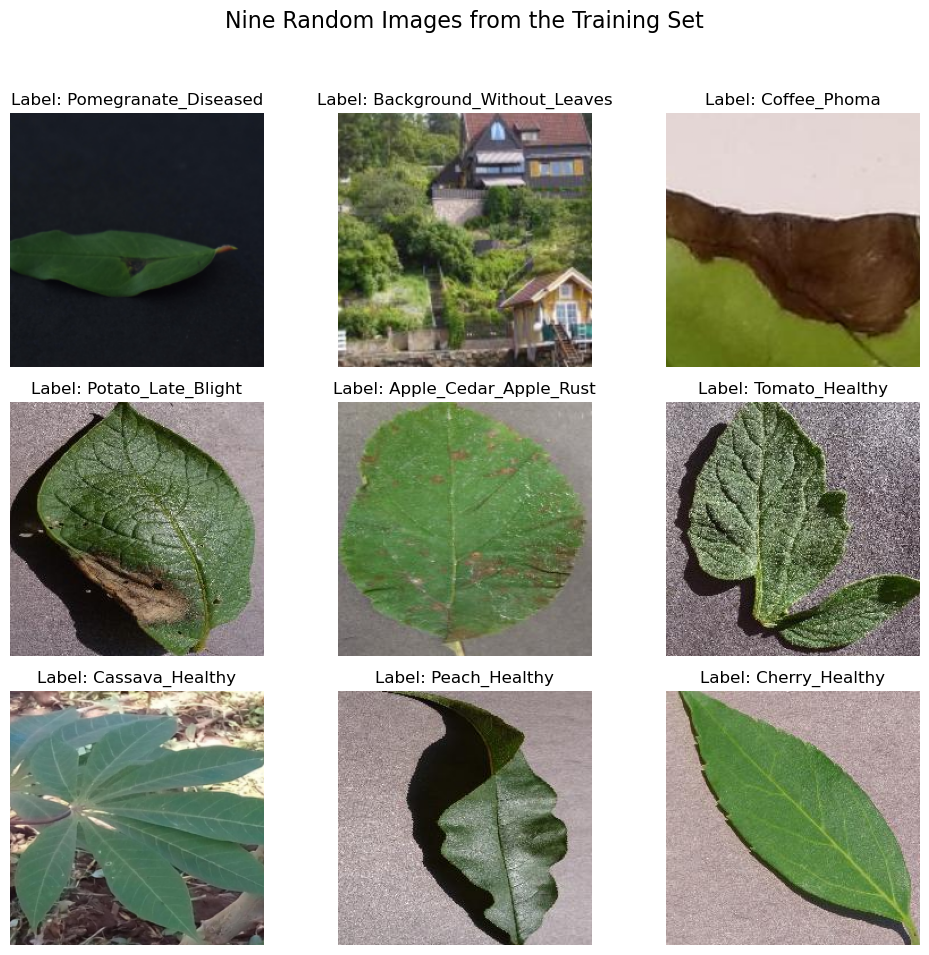

In [4]:
class_names = helpers.explore_data(train_dir, val_dir, test_dir)

## 4. Create the Data Loaders

Next, we'll create the data loaders for the training, validation and test sets. We'll apply some simple data augmentation to the training data. This is another thing that you could experiment with.

While the GPU does most of the calculations in training AI models, the CPU of the computer server is responsible for loading images from disk, doing any transformations and sending the data to the GPU. PyTorch takes care of all of this and takes care of doing this in parallel. For maximum GPU performance, multiple cores are needed to constantly feed data to the GPU. The number of workers (`num_workers`) argument controls how many parallel tasks should be running to load data. 

The code block below will detect if your notebook is running in a Slurm job by checking for the environment variable `SLURM_CPUS_PER_TASK` and using that to set the number of workers if it is defined. If it isn't defined, the code checks for the number of cores on your computer and uses that value. To manually set the number of workers, change the first line by adding the value you want to use.

In [5]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # Check if Slurm is being used
    # If Slurm is being used, set the number of workers to SLURM_CPUS_PER_TASK
    # If Slurm is not being used, set the number of workers to the number of available CPU cores
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
        print(f"Using {num_workers} workers for data loading.")
    else:
        num_workers = os.cpu_count()
        print(f"Using {num_workers} workers for data loading.")

Using 16 workers for data loading.


### Set up the data augmentation in the `data_transforms` `train` section:

In the code below, we are defining the transforms applied to images as they are loaded from disk and sent to the model. For the training data, data augmentation is a powerful method to increase the variability of the training data by randomly making changes to crop, orientation, color, etc. For more on data augmentation, see the *Practicum AI* Computer Vision course.

Here is an example set of transformations. Where you see the `FIX_ME` in the code block below, add or adjust these as you think are appropriate for the data. 

```python
[
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 10 degrees
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
]
```

In [6]:
# Allow loading of truncated images, since the dataset's images aren't all the same size!
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set the batch size
batch_size = 32

# Define PyTorch data transforms
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
            transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 10 degrees
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly crop and resize
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

# Load PyTorch datasets
image_datasets = {
    "train": datasets.ImageFolder(train_dir, data_transforms["train"]),
    "val": datasets.ImageFolder(val_dir, data_transforms["val"]),
    "test": datasets.ImageFolder(test_dir, data_transforms["test"]),
}

# Create PyTorch data loaders
dataloaders = {
    "train": torch.utils.data.DataLoader(
        image_datasets["train"],
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_workers,
    ),
    "val": torch.utils.data.DataLoader(
        image_datasets["val"],
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=num_workers,
    ),
    "test": torch.utils.data.DataLoader(
        image_datasets["test"],
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=num_workers,
    ),
}

## 5. Define the model


Our first model will be taking the approach of adapting a model for our new task. [EfficientNet](https://en.wikipedia.org/wiki/EfficientNet) is a class of models released by Google Research in 2019 ([Tan and Le, 2019](https://arxiv.org/abs/1905.11946)). Figure 1 from the Tan and Le (2019) paper is below, showing classification accuracy vs model size. The red line connecting them highlights the good performance of EfficientNet models with relatively few parameters, especially compared to the competing models of the time.

![Figure 1 from Tan and Le, 2019](images/EfficientNet_fig1.png)

We will start using the EfficientNet-B5 model as a good tradeoff between accuracy and model size, however, feel free to try different models. The model is imported in the imports cell above. See the [PyTorch documentation](https://pytorch.org/vision/main/models.html) on available models and pre-trained weights.


📝 **Note:**
If you'd like more information on how CNNs work, we explored them as part of Deep Learning Foundations (DLF) course, and have a full Computer Vision Intermediate course. 

In [7]:
# Define the number of classes in your dataset
num_classes = len(image_datasets["train"].classes)

# Load the EfficientNet-B5 model without pre-trained weights
effNet_random_wt = efficientnet_b5(weights=None)

# Replace the classifier (final layer) to match the number of classes
effNet_random_wt.classifier[1] = nn.Linear(
    effNet_random_wt.classifier[1].in_features, num_classes
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
effNet_random_wt.to(device)

# Print the model architecture (optional)
# You can right-click and select "Clear Cell Outputs" to clear the long model if you want
print(effNet_random_wt)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Set some hyperparameters

In [8]:
# Set Hyperparameters
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effNet_random_wt.parameters(), lr=0.001)

# How many epochs to run
epochs = 10

## 6. Set up the Pytorch Lightning training module

The `LightningModule` is used to organize all the training information into structured sections. Briefly, the following sections control:

* `__init__`: Initializes the model and sets up the data.
* `forward`: Manages the forward pass through the model.
* `training_step`:  Defines the training logic for a single batch.
* `validation_step`: Defines the validation logic for a single batch.
* `configure_optimizers`: Configures the optimizer(s) for training.


In [9]:
class model_Lightning(pl.LightningModule):
    def __init__(self, model, criterion, optimizer):
        super(model_Lightning, self).__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
        }  # Custom history variable

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.history["train_loss"].append(loss.item())  
        self.history["train_acc"].append(acc.item())  
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer


## 7. Run the training for the random weights

Now we are ready to train the model, using the EfficientNet-B5 architecture, starting with random weights.

### **Note**: This can take a lot of time

Depending on the CPU and GPU resources available to you, training this may take a fair bit of time (**upwards of 20 minutes in many cases**). While a powerful GPU helps, having access to 12+ cores can also speed things up. This notebook uses parallel data loaders to feed images to the model as quickly as possible. As the number of available processors increases, the processors can keep the GPU fed with input images. With fewer than 8 cores, the GPU sits idle for much of the time, waiting for data from the processors. The speed of your filesystem is also a component here, but not as easy to change.

**If you do not have the resources, or patience 😉, to train the model, skip the next cells, except the one in step 9.** We provide code in section 12 to download and import the results of a full training run.


In [ ]:
# Set up the logger
logger = pl.loggers.TensorBoardLogger('agrinet_logs', name = 'EffNetB5-random-wts')

# The trainer
trainer = Trainer(
    max_epochs = epochs,
    logger = logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu"
)
trainer.fit(
    model_Lightning(effNet_random_wt, criterion, optimizer),
    dataloaders["train"],
    dataloaders["val"],
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | EfficientNet     | 28.5 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
28.5 M    Trainable params
0         Non-trainable params
28.5 M    Total params
113.961   Total estimated model params size (MB)
790       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |                                                                                    | 0/? [0…

Training: |                                                                                           | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

`Trainer.fit` stopped: `max_epochs=10` reached.


## 8. Save the trained model

Finally, we'll save the trained model to a file. We'll use the `torch.save()` method to save the model to a file, and the `torch.load()` method to load the model from a file.

In [ ]:
# Create a folder to save the models if it does not exist
if not os.path.exists("models"):
    os.makedirs("models")

# Save the trained CNN model
torch.save(effNet_random_wt.state_dict(), "models/effNet_random_wt.pt")

## 9. Load the EfficientNet-B5 model wih pre-trained weights

Next we'll train the EfficientNet-B5 model, starting with the weights from training the model on ImageNet. The `weights=DEFAULT` uses the latest training weights, which as of this writing is ImageNet v.2. Using this will get the current state of the art for a model, but you should check to see what that is when selecting that option.

In [10]:
# Load the EfficientNet model, this time keeping the pre-trained weights
effNet_pretrain_wt = efficientnet_b5(weights="DEFAULT")
# Freeze all layers except the classifier
for param in effNet_pretrain_wt.parameters():
    param.requires_grad = False
# Replace the classifier (final layer) to match the number of classes
effNet_pretrain_wt.classifier[1] = nn.Linear(
    effNet_pretrain_wt.classifier[1].in_features, num_classes
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
effNet_pretrain_wt.to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effNet_pretrain_wt.parameters(), lr=0.001)

# Print the model summary (optional; uncomment the next line to print the model)
# print(effNet_pretrain_wt)

# 10. Fine-tune the EfficientNet-B5 model

Next we'll train the EfficientNet-B5 model, starting with the weights from training the model on ImageNet.

In [ ]:
# Set up the logger
logger = pl.loggers.TensorBoardLogger('agrinet_logs', name = 'EffNetB5-pretrained-wts')

# The trainer
trainer = Trainer(
    max_epochs = epochs,
    logger = logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu"
)
trainer.fit(
    model_Lightning(effNet_pretrain_wt, criterion, optimizer),
    dataloaders["train"],
    dataloaders["val"],
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | EfficientNet     | 28.5 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
149 K     Trainable params
28.3 M    Non-trainable params
28.5 M    Total params
113.961   Total estimated model params size (MB)
790       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |                                                                                    | 0/? [0…

Training: |                                                                                           | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

Validation: |                                                                                         | 0/? [0…

`Trainer.fit` stopped: `max_epochs=10` reached.


## 11. Save the EfficientNet-B5 trained from pre-trained weights model

Finally, we'll save the trained model to a file. We'll use the `torch.save()` method to save the model to a file, and the `torch.load()` method to load the model from a file.

In [ ]:
# Create a folder to save the models if it does not exist
if not os.path.exists("models"):
    os.makedirs("models")

# Save the fine-tuned EfficientNet-B5 model
torch.save(effNet_pretrain_wt.state_dict(), "models/effNet_pretrain_wt.pt")

## 12. Explore the results of each training run

From the information displayed during training, it should already be clear that the model starting from pre-trained weights did much better! Typical accuracies starting from scratch are around 40%, while when starting with pre-trained weights, they are closer to 80%!




#### If you did If you did not run the training
> If you did not run the training, you can load a saved checkpoint using the code below.
>
> Uncomment the lines by **selecting all of the lines in the block** and using the keyboard shortcut **Ctrl-/**


In [11]:
# Only uncomment this block if you did not train the models and need to 
# download checkpoints.

# Download and extract the model training checkpoints
download_url = "https://data.rc.ufl.edu/pub/practicum-ai/Transfer_Learning"
file_name = "agrinet_checkpoints.tar.gz"
checkpoint_path = "agrinet_logs"
folder_names = ["EffNetB5-pretrained-wts", "EffNetB5-random-wts"]

helpers.download_and_extract_data(download_url, file_name, checkpoint_path, folder_names)

# Load the trained model starting from random weights
effNet_random_wt = model_Lightning.load_from_checkpoint('agrinet_logs/EffNetB5-random-wts/version_0/checkpoints/epoch=9-step=2250.ckpt',
											model=effNet_random_wt,
											criterion=criterion,
											optimizer=optimizer)

# Load the trained model starting from pre-trained weights
effNet_pretrain_wt = model_Lightning.load_from_checkpoint('agrinet_logs/EffNetB5-pretrained-wts/version_0/checkpoints/epoch=9-step=2250.ckpt',
											model=effNet_pretrain_wt,
											criterion=criterion,
											optimizer=optimizer)

Data is already downloaded.


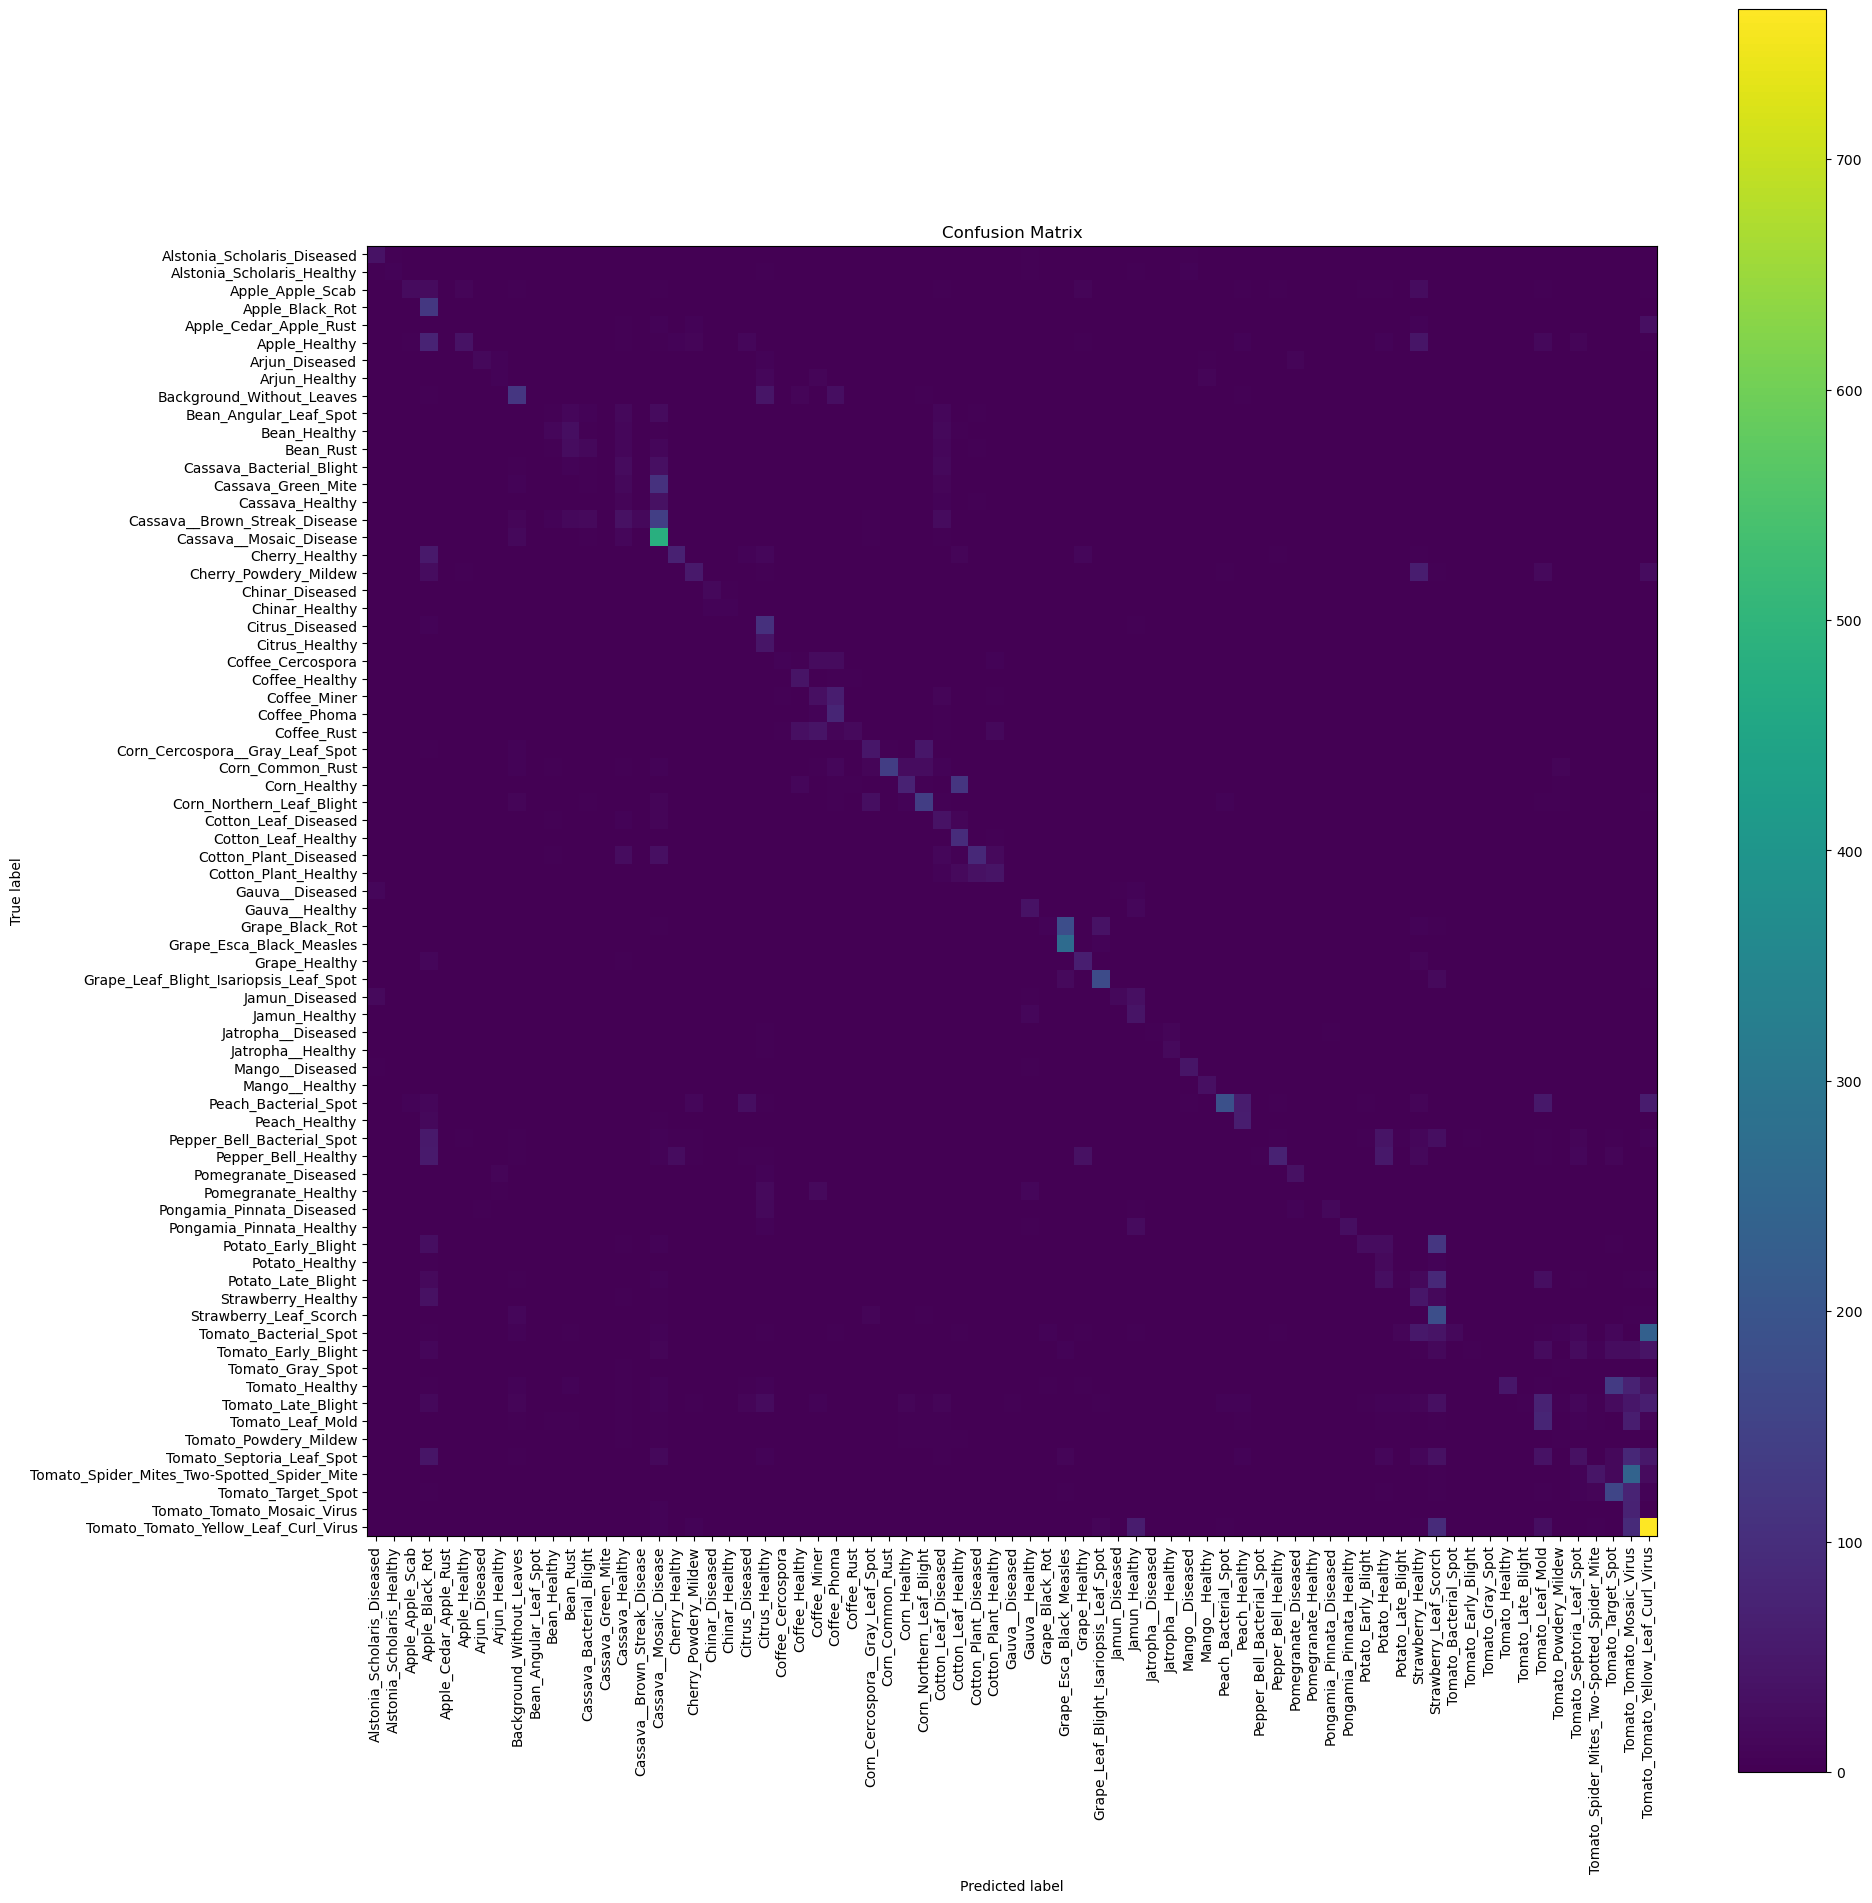

In [12]:

# Plot confusion matrix for the random weights EfficientNet-B5 model
helpers.plot_confusion_matrix(effNet_random_wt, dataloaders["test"], class_names)


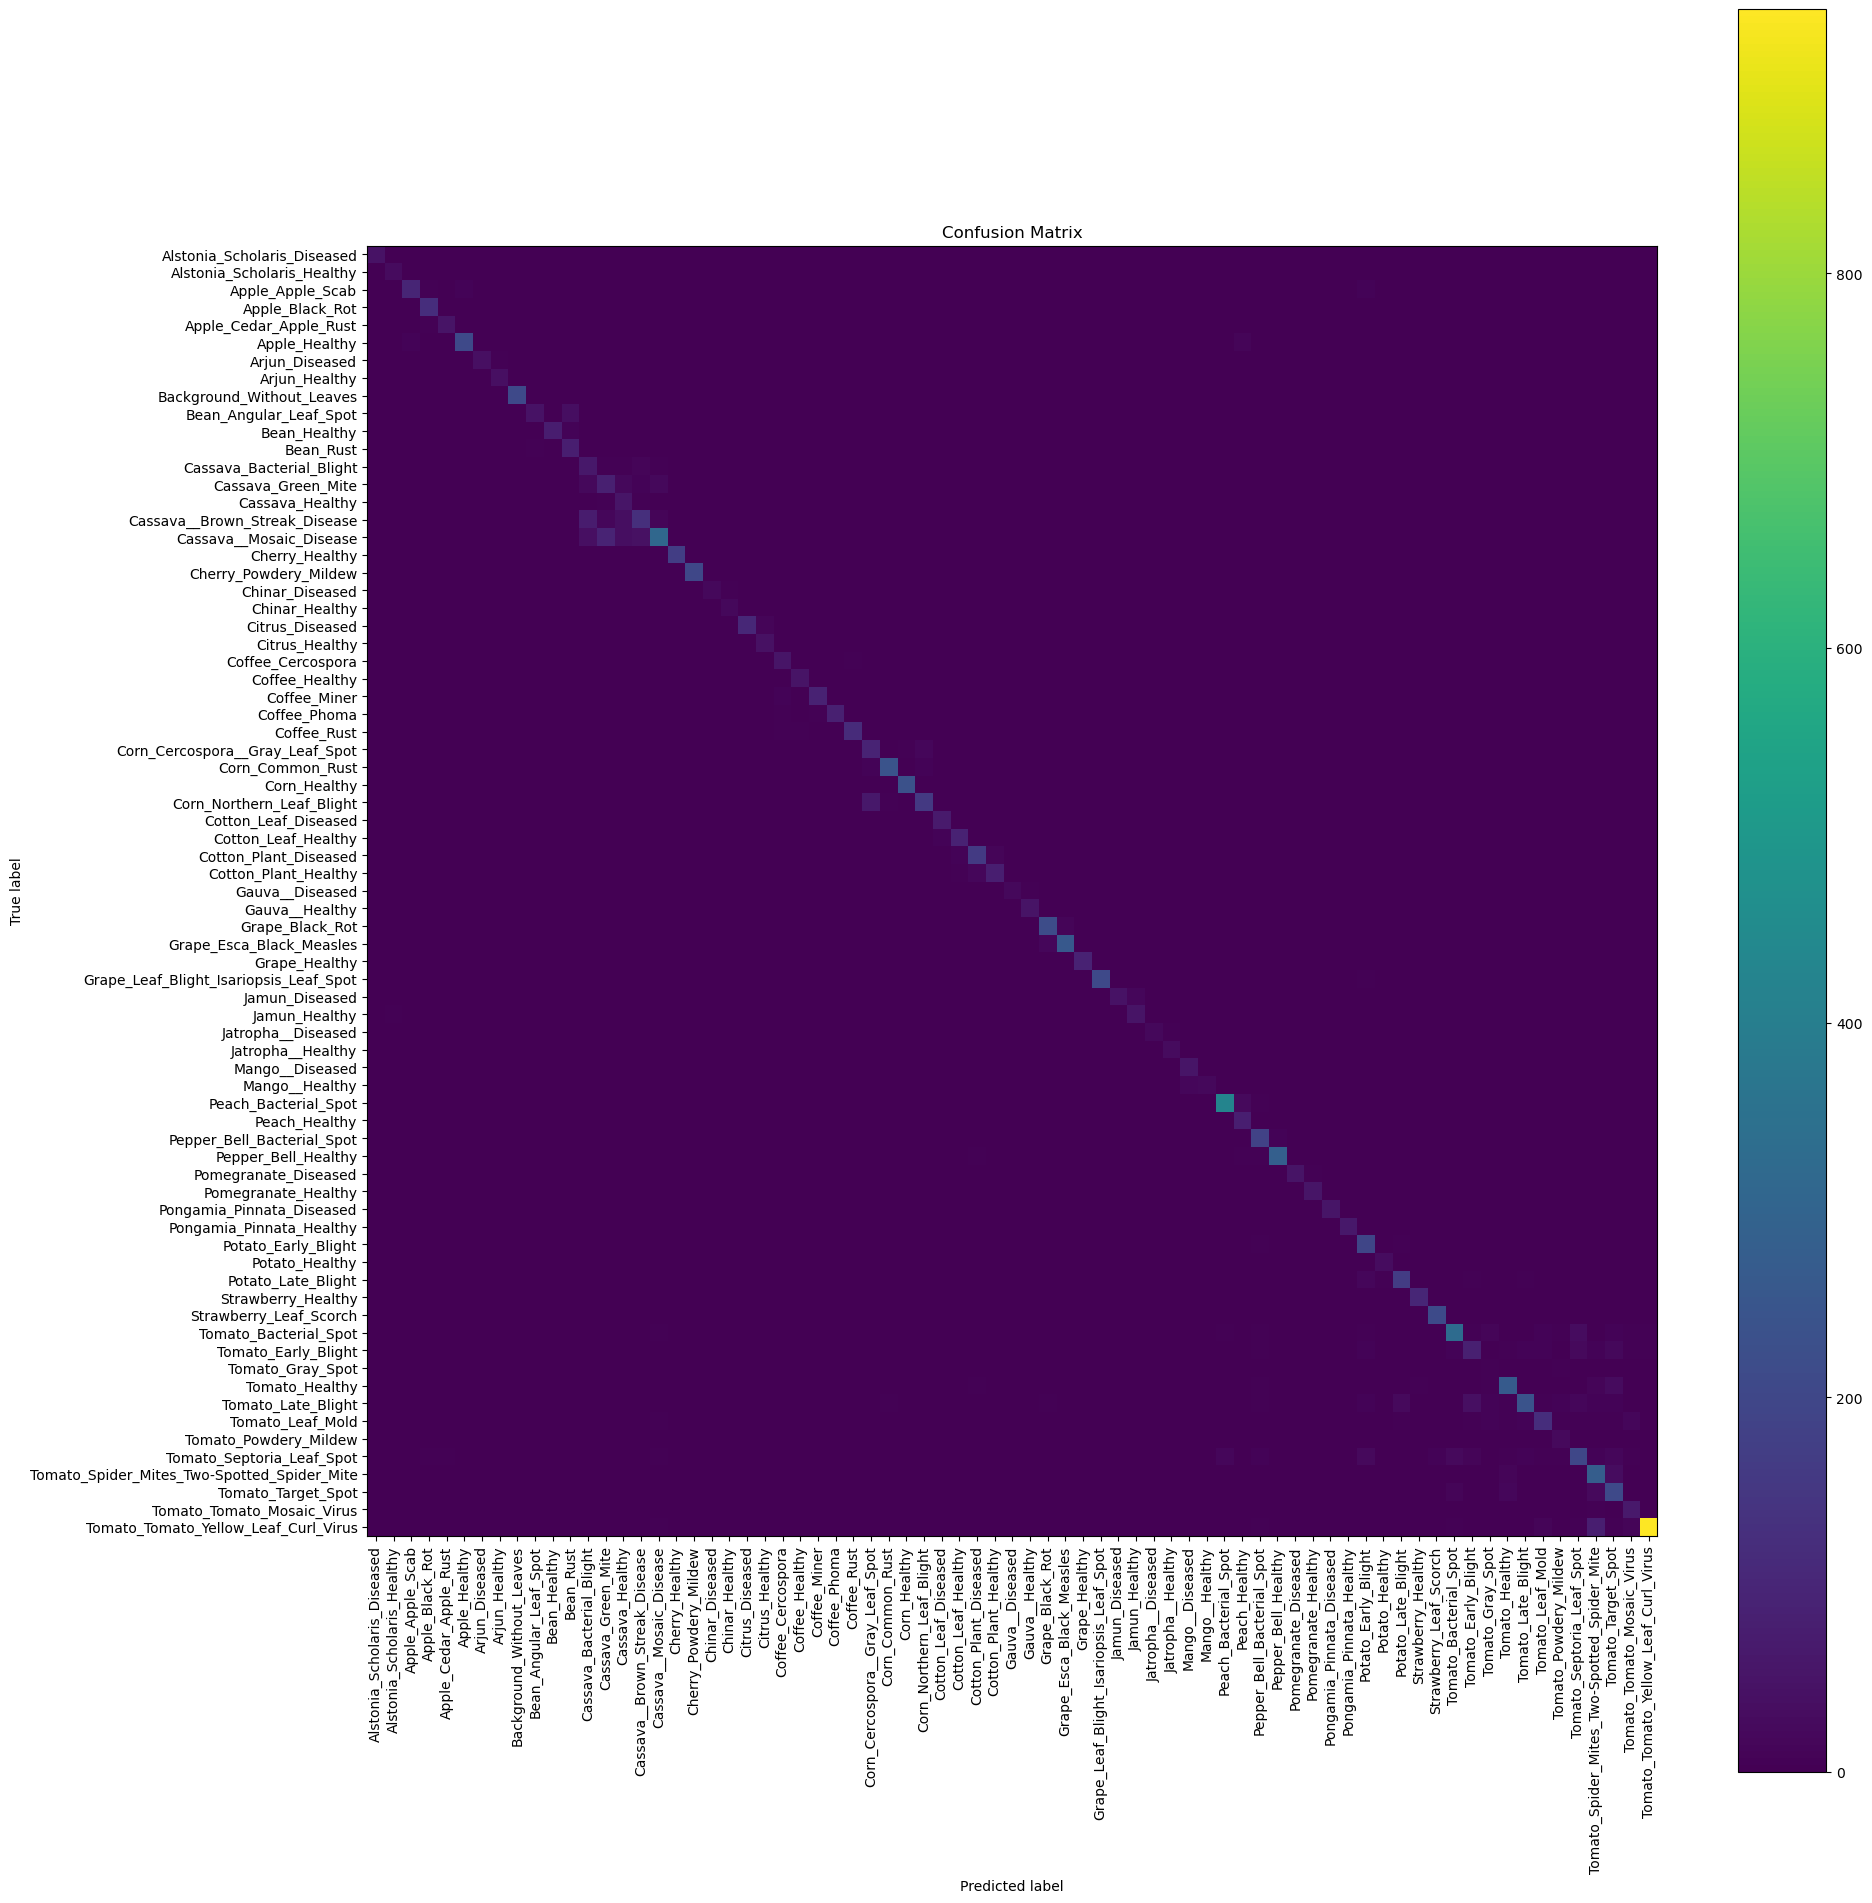

In [13]:
# Plot confusion matrix for the fine-tuned EfficientNet-B5 model
helpers.plot_confusion_matrix(effNet_pretrain_wt, dataloaders["test"], class_names)


In [ ]:
# Save the confusion matrix plot
plt.savefig("confusion_matrix.png")


<Figure size 640x480 with 0 Axes>